In [1]:
import pandas as pd
from matplotlib import pyplot as plt 
import pyarrow.parquet as pa
import seaborn as sns
from scipy import stats
import numpy as np

In [2]:
df = pd.read_parquet('../data/all_data.parquet')
df.shape

(577518, 35)

In [3]:
df.columns

Index(['Время', 'Мощность МПСИ кВт', 'Мощность МШЦ кВт', 'Ток МПСИ А',
       'Ток МШЦ А', 'Исходное питание МПСИ т/ч', 'Возврат руды МПСИ т/ч',
       'Общее питание МПСИ т/ч', 'Расход воды МПСИ PV м3/ч',
       'Расход воды МПСИ SP м3/ч', 'Расход воды МПСИ CV %',
       'факт соотношение руда/вода МПСИ',
       'Давление на подшипник МПСИ загрузка Бар',
       'Давление на подшипник МПСИ разгрузка Бар',
       'Температура масла основной маслостанции подача МПСИ',
       'Температура масла основной маслостанции слив МПСИ',
       'Температура масла маслостанции электродвигатель МПСИ',
       'Температура масла редуктора МПСИ',
       'Давление на подшипник МШЦ загрузка Бар',
       'Давление на подшипник МШЦ разгрузка Бар',
       'Температура масла основной маслостанции подача МШЦ',
       'Температура масла основной маслостанции слив МШЦ',
       'Температура масла маслостанции электродвигатель МШЦ',
       'Температура масла редуктора МШЦ', 'Расход извести МШЦ л/ч',
       'Уровен

##  Предобработка данных

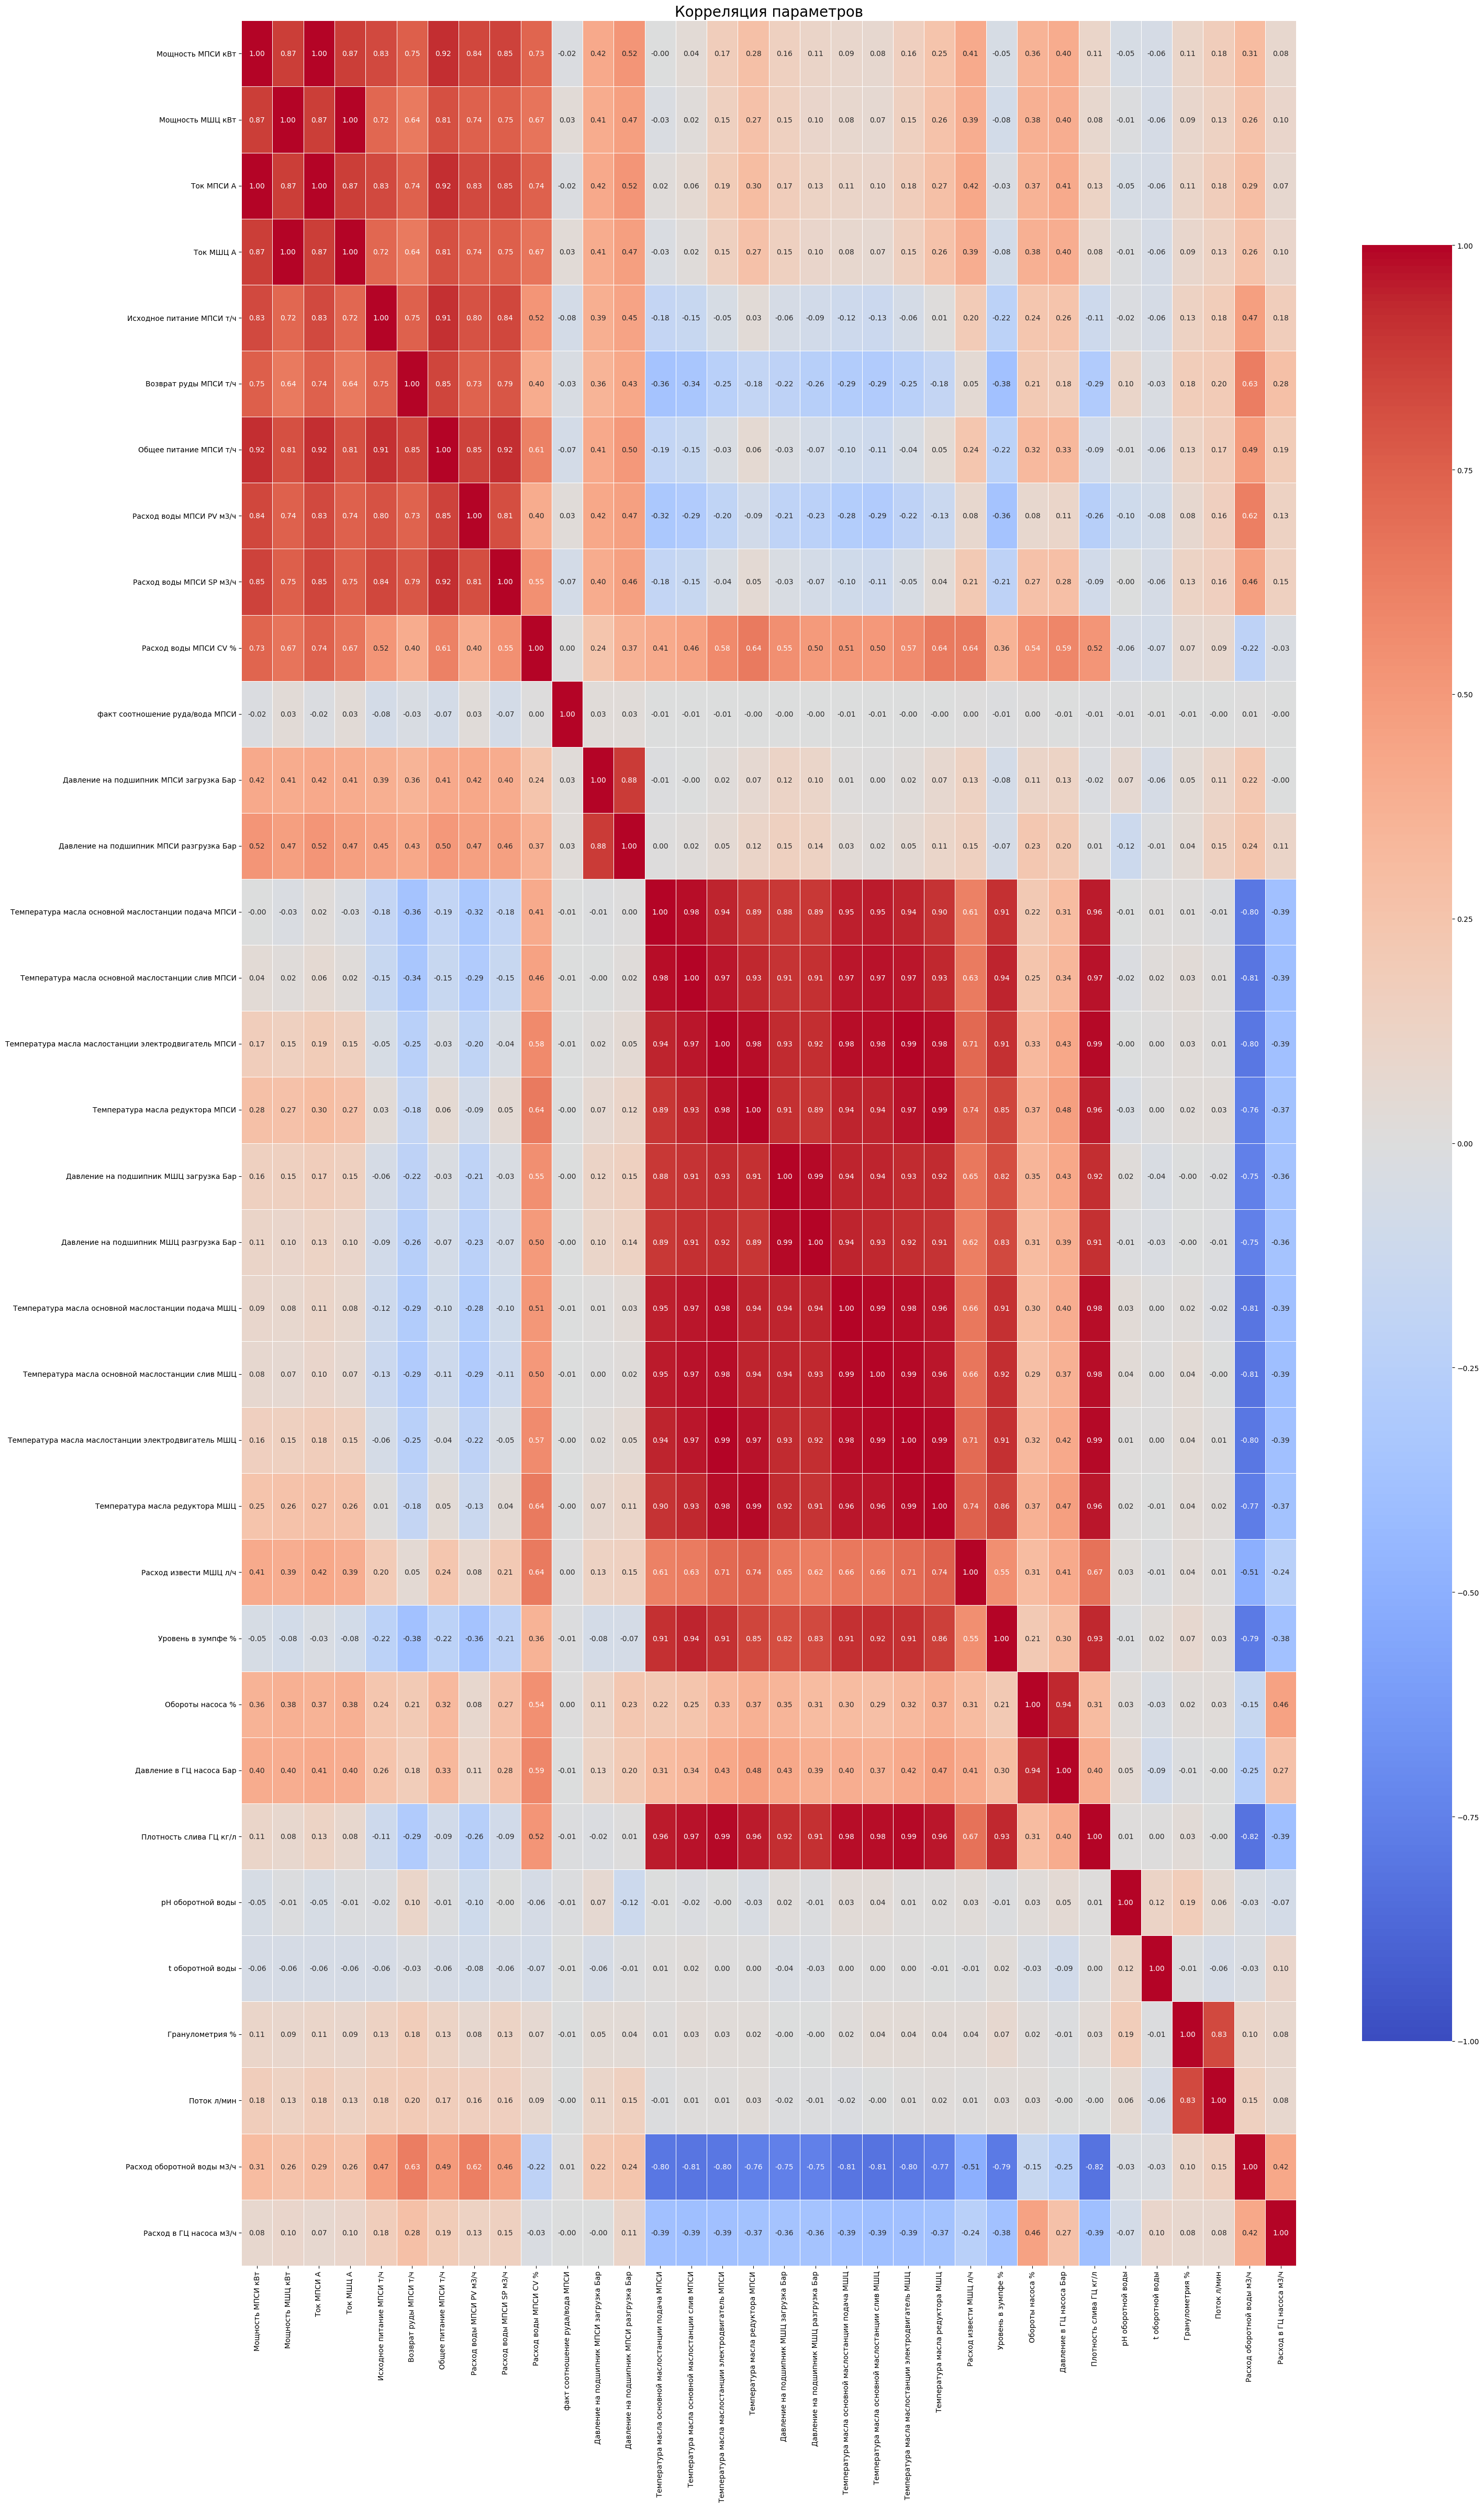

In [4]:
correlation_matrix = df.drop(columns=['Время']).corr()

plt.figure(figsize=(30, 48))  # Увеличил размер фигуры примерно в 3 раза

sns.heatmap(correlation_matrix, 
            annot=True,           # Показывать значения
            fmt='.2f',            # Формат чисел (2 десятичных знака)
            cmap='coolwarm',      # Цветовая схема
            center=0,             # Центр цветовой шкалы
            vmin=-1,              # Минимальное значение
            vmax=1,
            linewidths=0.5,       # Добавил линии между ячейками для лучшей читаемости
            cbar_kws={'shrink': .8})  # Немного уменьшил размер цветовой шкалы

plt.title('Корреляция параметров', fontsize=20)  # Увеличил размер заголовка
plt.tight_layout()  # Улучшил компоновку

In [5]:
correlation_matrix['Гранулометрия %'].sort_values(ascending=False)

Гранулометрия %                                         1.000000
Поток л/мин                                             0.829650
pH оборотной воды                                       0.187252
Возврат руды МПСИ т/ч                                   0.184368
Исходное питание МПСИ т/ч                               0.133128
Общее питание МПСИ т/ч                                  0.129103
Расход воды МПСИ SP м3/ч                                0.128035
Мощность МПСИ кВт                                       0.108638
Ток МПСИ А                                              0.107576
Расход оборотной воды м3/ч                              0.102358
Мощность МШЦ кВт                                        0.091556
Ток МШЦ А                                               0.091542
Расход в ГЦ насоса м3/ч                                 0.083984
Расход воды МПСИ PV м3/ч                                0.077346
Уровень в зумпфе %                                      0.073244
Расход воды МПСИ CV %    

### 1. Количество пустых значений в начальном датасете

In [6]:
print(df.isna().sum(axis=0))

print(f'\n\nПроцентное соотношение пропусков: {df.isna().sum(axis=0).max()/len(df)*100}%')

Время                                                       0
Мощность МПСИ кВт                                          50
Мощность МШЦ кВт                                           50
Ток МПСИ А                                                 50
Ток МШЦ А                                                  50
Исходное питание МПСИ т/ч                                  50
Возврат руды МПСИ т/ч                                      50
Общее питание МПСИ т/ч                                     50
Расход воды МПСИ PV м3/ч                                   50
Расход воды МПСИ SP м3/ч                                   50
Расход воды МПСИ CV %                                      50
факт соотношение руда/вода МПСИ                            50
Давление на подшипник МПСИ загрузка Бар                    50
Давление на подшипник МПСИ разгрузка Бар                   50
Температура масла основной маслостанции подача МПСИ        25
Температура масла основной маслостанции слив МПСИ          25
Температ

# Анализ Потока

В нашем датасете есть **178099** строчек, где Поток = 0

In [7]:
is_potok0 = (df['Поток л/мин'] == 0).values
potok0_inds = [ i for i in range(len(is_potok0)) if is_potok0[i] ]
len(potok0_inds)

178099

При потоке=0 мы видим, что 178097 значений Гранулометрии = 0, что составляет **99.998%**, значит в этот момент ничего не работало, можем удалить эти строчки

In [8]:
cnt_gralunometr0_potok0 = 0

for ind in potok0_inds:
    if df['Гранулометрия %'][ind] == 0:
        cnt_gralunometr0_potok0 += 1

print(cnt_gralunometr0_potok0)
f'Соотношение Гранулометрии = 0 при Потоке = 0: {cnt_gralunometr0_potok0/len(potok0_inds)*100}%'



178097


'Соотношение Гранулометрии = 0 при Потоке = 0: 99.9988770290681%'

In [9]:
print('длина до удаления строк с Потоком = 0:', df.shape)
df.drop(potok0_inds, inplace=True)
print('длина после удаления строк с Потоком = 0:', df.shape)

длина до удаления строк с Потоком = 0: (577518, 35)
длина после удаления строк с Потоком = 0: (399419, 35)


Продолжаем анализировать наши данные потока, сделаем гистограмму распределения потока

Text(0, 0.5, 'Частота')

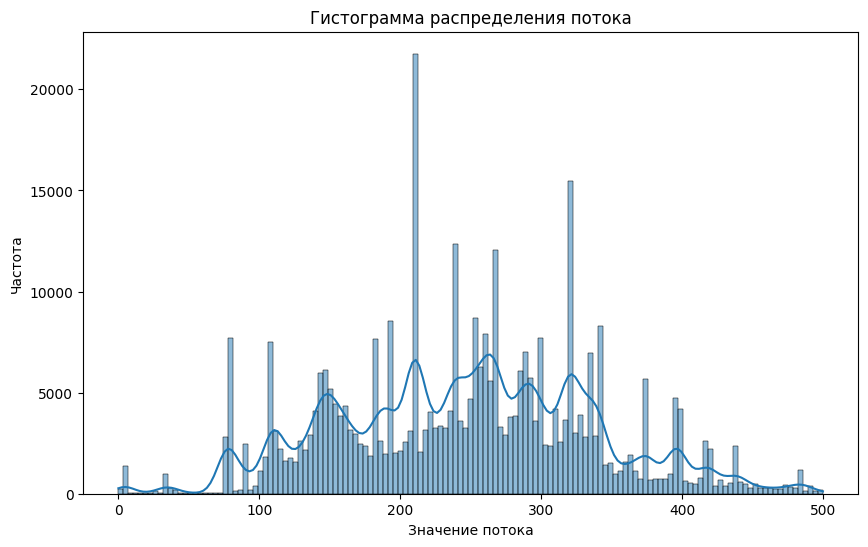

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(data=df, x='Поток л/мин', kde=True, ax=axes)
axes.set_title('Гистограмма распределения потока')
axes.set_xlabel('Значение потока')
axes.set_ylabel('Частота')

Есть 17901 пропущенных значений потока, попробуем восстановить их с помощью медианы

In [11]:
df['Поток л/мин'].isna().sum()

17901

In [12]:
# Получаем индексы строк с пропущенными значениями потока
missing_flow_mask = df['Поток л/мин'].isna()
# Получаем индексы строк где гранулометрия = 0
zero_granulometry_mask = df['Гранулометрия %'] == 0
# Находим пересечение масок
zero_gran_missing_flow = missing_flow_mask & zero_granulometry_mask
# Выводим индексы строк где есть пересечение
print(df[zero_gran_missing_flow].index.tolist())


[]


In [13]:
df['Поток л/мин'] = df['Поток л/мин'].fillna(df['Поток л/мин'].median())

Посмотрим на новую гистограмму распределения потока, уже выглядит получше

Text(0, 0.5, 'Частота')

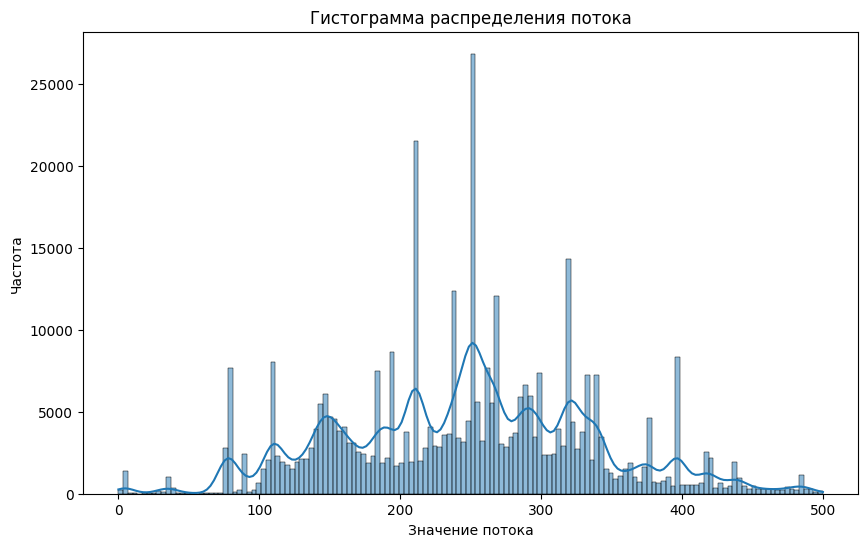

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(data=df, x='Поток л/мин', kde=True, ax=axes)
axes.set_title('Гистограмма распределения потока')
axes.set_xlabel('Значение потока')
axes.set_ylabel('Частота')

Теперь узнаем какие параметры сильно коррелируют между собой

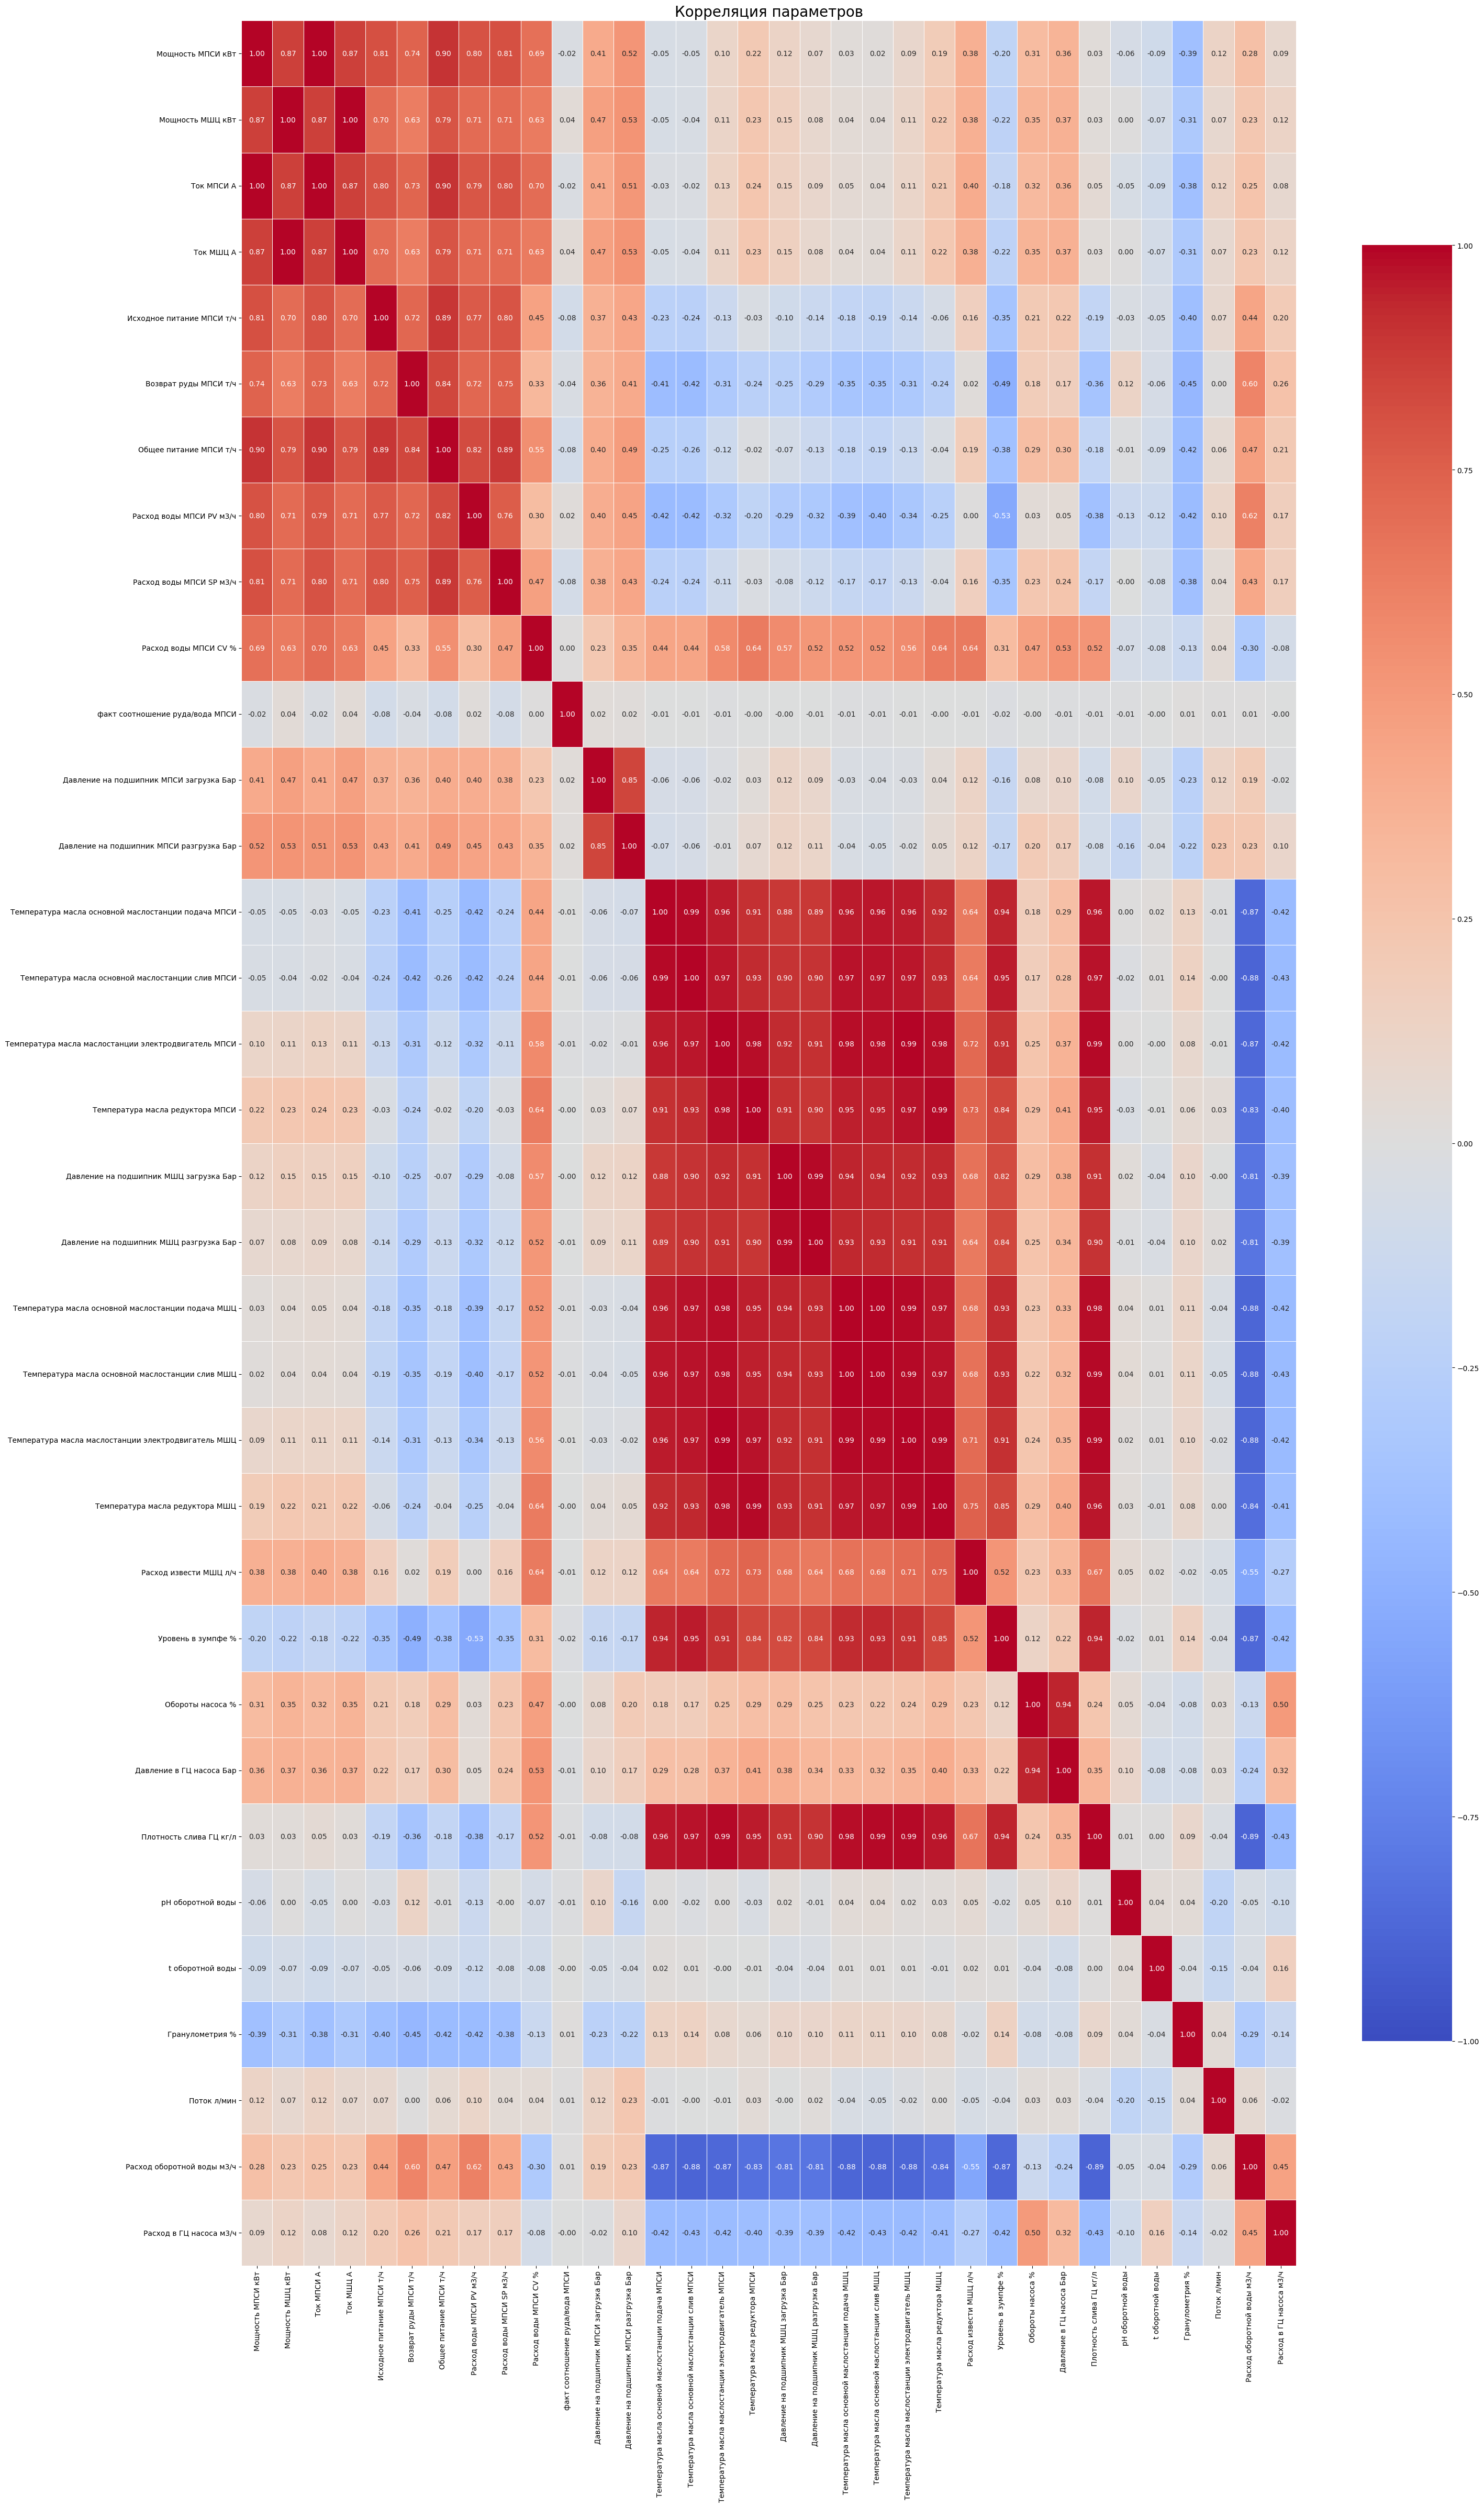

In [15]:
correlation_matrix = df.drop(columns=['Время']).corr()

plt.figure(figsize=(30, 48))  # Увеличил размер фигуры примерно в 3 раза

sns.heatmap(correlation_matrix, 
            annot=True,           # Показывать значения
            fmt='.2f',            # Формат чисел (2 десятичных знака)
            cmap='coolwarm',      # Цветовая схема
            center=0,             # Центр цветовой шкалы
            vmin=-1,              # Минимальное значение
            vmax=1,
            linewidths=0.5,       # Добавил линии между ячейками для лучшей читаемости
            cbar_kws={'shrink': .8})  # Немного уменьшил размер цветовой шкалы

plt.title('Корреляция параметров', fontsize=20)  # Увеличил размер заголовка
plt.tight_layout()  # Улучшил компоновку

### Создаем подграфики для разных типов визуализации

Text(0, 0.5, 'Значение потока')

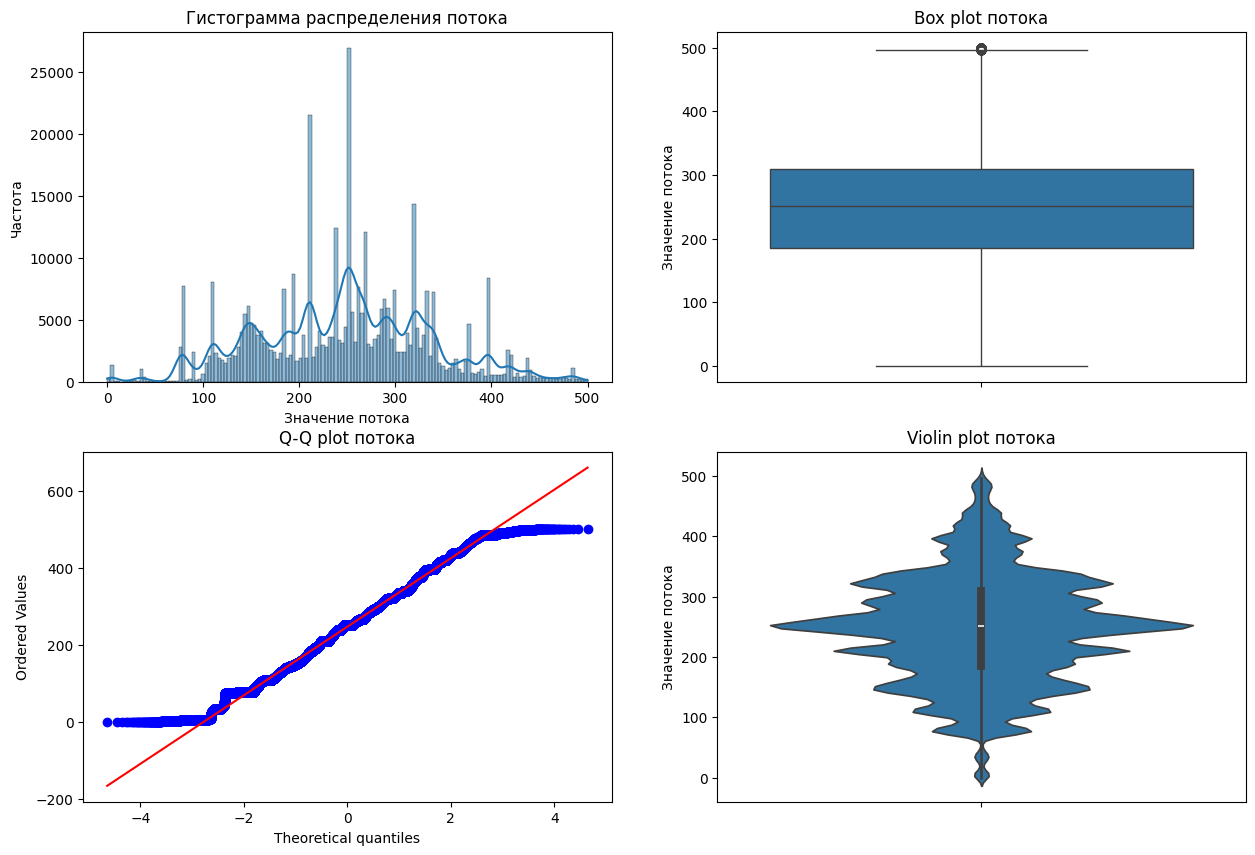

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Гистограмма с кривой плотности
sns.histplot(data=df, x='Поток л/мин', kde=True, ax=axes[0,0])
axes[0,0].set_title('Гистограмма распределения потока')
axes[0,0].set_xlabel('Значение потока')
axes[0,0].set_ylabel('Частота')

# (Box plot)
sns.boxplot(data=df, y='Поток л/мин', ax=axes[0,1])
axes[0,1].set_title('Box plot потока')
axes[0,1].set_ylabel('Значение потока')

# QQ-plot для проверки на нормальность
stats.probplot(df['Поток л/мин'].dropna(), dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q plot потока')

# Violin plot
sns.violinplot(data=df, y='Поток л/мин', ax=axes[1,1])
axes[1,1].set_title('Violin plot потока')
axes[1,1].set_ylabel('Значение потока')


# Создаем график зависимости гранулометрии от потока

In [17]:
df.columns

Index(['Время', 'Мощность МПСИ кВт', 'Мощность МШЦ кВт', 'Ток МПСИ А',
       'Ток МШЦ А', 'Исходное питание МПСИ т/ч', 'Возврат руды МПСИ т/ч',
       'Общее питание МПСИ т/ч', 'Расход воды МПСИ PV м3/ч',
       'Расход воды МПСИ SP м3/ч', 'Расход воды МПСИ CV %',
       'факт соотношение руда/вода МПСИ',
       'Давление на подшипник МПСИ загрузка Бар',
       'Давление на подшипник МПСИ разгрузка Бар',
       'Температура масла основной маслостанции подача МПСИ',
       'Температура масла основной маслостанции слив МПСИ',
       'Температура масла маслостанции электродвигатель МПСИ',
       'Температура масла редуктора МПСИ',
       'Давление на подшипник МШЦ загрузка Бар',
       'Давление на подшипник МШЦ разгрузка Бар',
       'Температура масла основной маслостанции подача МШЦ',
       'Температура масла основной маслостанции слив МШЦ',
       'Температура масла маслостанции электродвигатель МШЦ',
       'Температура масла редуктора МШЦ', 'Расход извести МШЦ л/ч',
       'Уровен

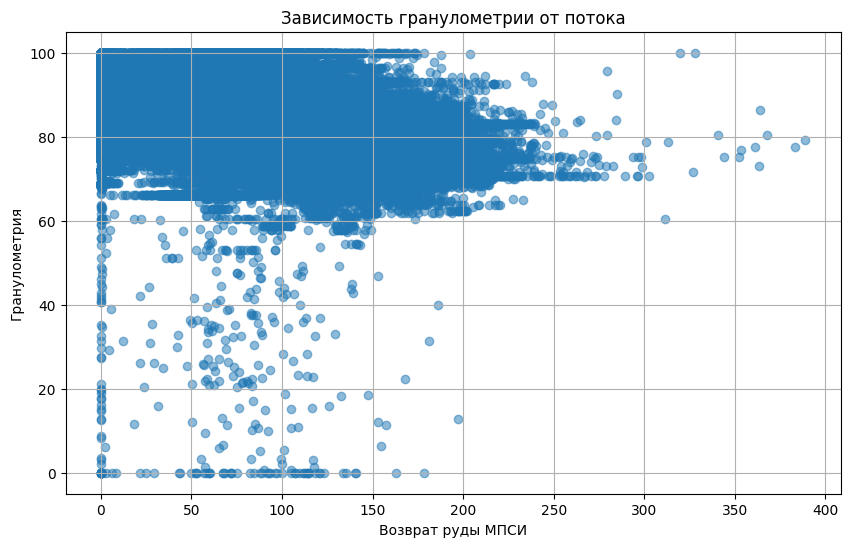

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Возврат руды МПСИ т/ч'], df['Гранулометрия %'], alpha=0.5)
plt.title('Зависимость гранулометрии от потока')
plt.xlabel('Возврат руды МПСИ')
plt.ylabel('Гранулометрия')
plt.grid(True)


### Вывод основных статистик

In [19]:
print("\nОсновные статистические показатели потока:")
print(df['Поток л/мин'].describe())


Основные статистические показатели потока:
count    399419.000000
mean        247.029634
std          89.140923
min           0.002083
25%         184.369644
50%         250.440872
75%         308.934875
max         499.989227
Name: Поток л/мин, dtype: float64


### Расчет асимметрии и эксцесса


In [20]:
print("\nДополнительные характеристики распределения:")
print(f"Асимметрия: {df['Поток л/мин'].skew():.3f}")
print(f"Эксцесс: {df['Поток л/мин'].kurtosis():.3f}")


Дополнительные характеристики распределения:
Асимметрия: 0.062
Эксцесс: -0.205


### Определение выбросов методом межквартильного размаха

In [21]:
Q1 = df['Поток л/мин'].quantile(0.25)
Q3 = df['Поток л/мин'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Поток л/мин'] < lower_bound) | (df['Поток л/мин'] > upper_bound)]['Поток л/мин']
print(f"\nКоличество выбросов: {len(outliers)}")
print(f"Процент выбросов: {(len(outliers)/len(df['Поток л/мин'])*100):.2f}%")
print(f"Нижняя граница выбросов: {lower_bound:.2f}")
print(f"Верхняя граница выбросов: {upper_bound:.2f}")


Количество выбросов: 212
Процент выбросов: 0.05%
Нижняя граница выбросов: -2.48
Верхняя граница выбросов: 495.78


### График плотности с выбросами

Text(0.5, 1.0, 'Распределение потока с границами выбросов')

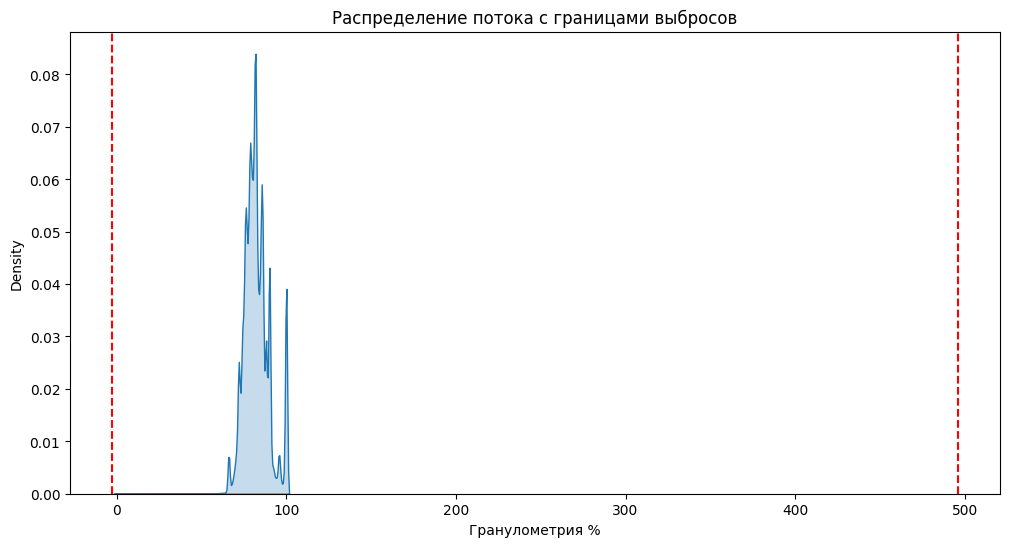

In [22]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='Гранулометрия %', fill=True)
plt.axvline(x=lower_bound, color='r', linestyle='--', label='Границы выбросов')
plt.axvline(x=upper_bound, color='r', linestyle='--')
plt.title('Распределение потока с границами выбросов')

# Оценка важности параметров для предсказания Гранулометрии

In [23]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [24]:
df = df.dropna()
df["Гранулометрия %"].isna().sum()

0

In [25]:
# Преобразуем столбец 'Время' в datetime
df['Время'] = pd.to_datetime(df['Время'])

In [26]:
df.to_parquet('../data/data_after_analys.parquet')

In [27]:
X = df.drop(['Гранулометрия %'], axis=1)
y = df['Гранулометрия %']

In [28]:
# Преобразуем данные в числовой формат
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean())

In [29]:
print("Типы данных в признаках:")
print(X.dtypes)

Типы данных в признаках:
Время                                                     int64
Мощность МПСИ кВт                                       float64
Мощность МШЦ кВт                                        float64
Ток МПСИ А                                              float64
Ток МШЦ А                                               float64
Исходное питание МПСИ т/ч                               float64
Возврат руды МПСИ т/ч                                   float64
Общее питание МПСИ т/ч                                  float64
Расход воды МПСИ PV м3/ч                                float64
Расход воды МПСИ SP м3/ч                                float64
Расход воды МПСИ CV %                                   float64
факт соотношение руда/вода МПСИ                         float64
Давление на подшипник МПСИ загрузка Бар                 float64
Давление на подшипник МПСИ разгрузка Бар                float64
Температура масла основной маслостанции подача МПСИ     float64
Температура мас

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Масштабирование признаков
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_train = pd.DataFrame(X_scaled_train, columns=X_train.columns)
X_scaled_test = scaler.transform(X_test)
X_scaled_test = pd.DataFrame(X_scaled_test, columns=X_test.columns)

## Делаем РандомФорест

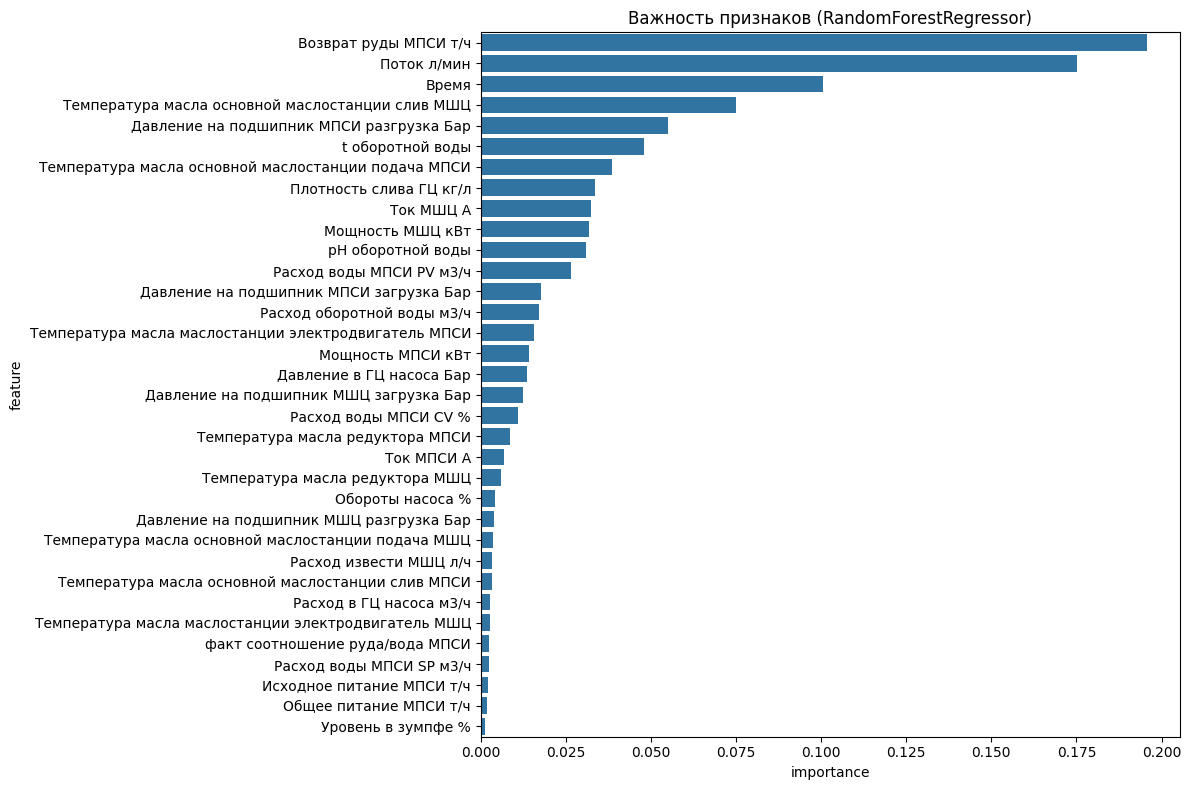


Топ-10 признаков по RandomForestRegressor:
                                              feature  importance
6                               Возврат руды МПСИ т/ч    0.195646
31                                        Поток л/мин    0.175210
0                                               Время    0.100557
21   Температура масла основной маслостанции слив МШЦ    0.074923
13           Давление на подшипник МПСИ разгрузка Бар    0.055113
30                                   t оборотной воды    0.047995
14  Температура масла основной маслостанции подача...    0.038551
28                            Плотность слива ГЦ кг/л    0.033670
4                                           Ток МШЦ А    0.032333
2                                    Мощность МШЦ кВт    0.031801


In [32]:
#  RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=5, random_state=42)
rf_model.fit(X_scaled_train, y_train)

# Важность признаков из RandomForestRegressor
gb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
gb_importance = gb_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=gb_importance)
plt.title('Важность признаков (RandomForestRegressor)')
plt.tight_layout()
plt.show()

print("\nТоп-10 признаков по RandomForestRegressor:")
print(gb_importance.head(10))

Метрики качества модели на тестовой выборке:
Среднеквадратичная ошибка (MSE): 2.8245
Корень из среднеквадратичной ошибки (RMSE): 1.6806
Коэффициент детерминации (R²): 0.9476
Медианная абсолютная ошибка (MAE): 0.0055



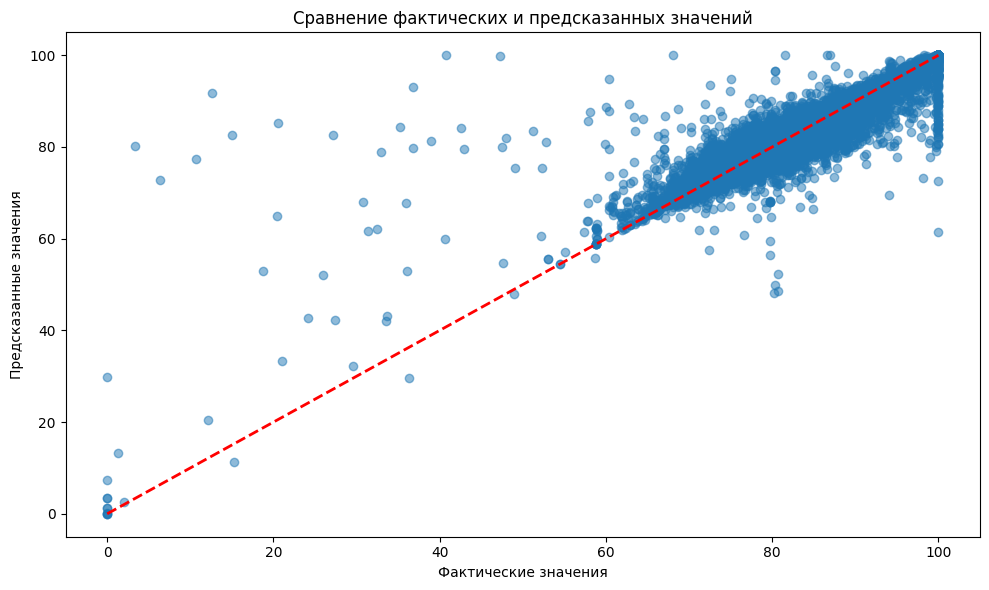

In [33]:
from sklearn.metrics import mean_squared_error, r2_score

# Делаем предсказания на тестовом наборе
y_pred = rf_model.predict(X_scaled_test)

# Оцениваем качество модели
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Метрики качества модели на тестовой выборке:")
print(f"Среднеквадратичная ошибка (MSE): {mse:.4f}")
print(f"Корень из среднеквадратичной ошибки (RMSE): {rmse:.4f}") 
print(f"Коэффициент детерминации (R²): {r2:.4f}")
from sklearn.metrics import median_absolute_error
mae = median_absolute_error(y_test, y_pred)
print(f"Медианная абсолютная ошибка (MAE): {mae:.4f}")
print()

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение фактических и предсказанных значений')
plt.tight_layout()
plt.show()


## Делаем CatBoost

In [34]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(n_estimators=10, random_state=42)
cat_model.fit(X_scaled_train, y_train)

y_pred_cat = cat_model.predict(X_scaled_test)

mse_cat = mean_squared_error(y_test, y_pred_cat)
rmse_cat = np.sqrt(mse_cat)
r2_cat = r2_score(y_test, y_pred_cat)


Learning rate set to 0.5
0:	learn: 5.8525148	total: 276ms	remaining: 2.48s
1:	learn: 5.2547031	total: 342ms	remaining: 1.37s
2:	learn: 4.9122492	total: 401ms	remaining: 935ms
3:	learn: 4.6650453	total: 465ms	remaining: 697ms
4:	learn: 4.5382330	total: 530ms	remaining: 530ms
5:	learn: 4.4231142	total: 590ms	remaining: 394ms
6:	learn: 4.3273766	total: 654ms	remaining: 280ms
7:	learn: 4.2103539	total: 725ms	remaining: 181ms
8:	learn: 4.1512938	total: 789ms	remaining: 87.6ms
9:	learn: 4.1073731	total: 841ms	remaining: 0us


Метрики качества модели CatBoost на тестовой выборке:
Среднеквадратичная ошибка (MSE): 16.9026
Корень из среднеквадратичной ошибки (RMSE): 4.1113
Коэффициент детерминации (R²): 0.6866
Медианная абсолютная ошибка (MAE): 1.9131



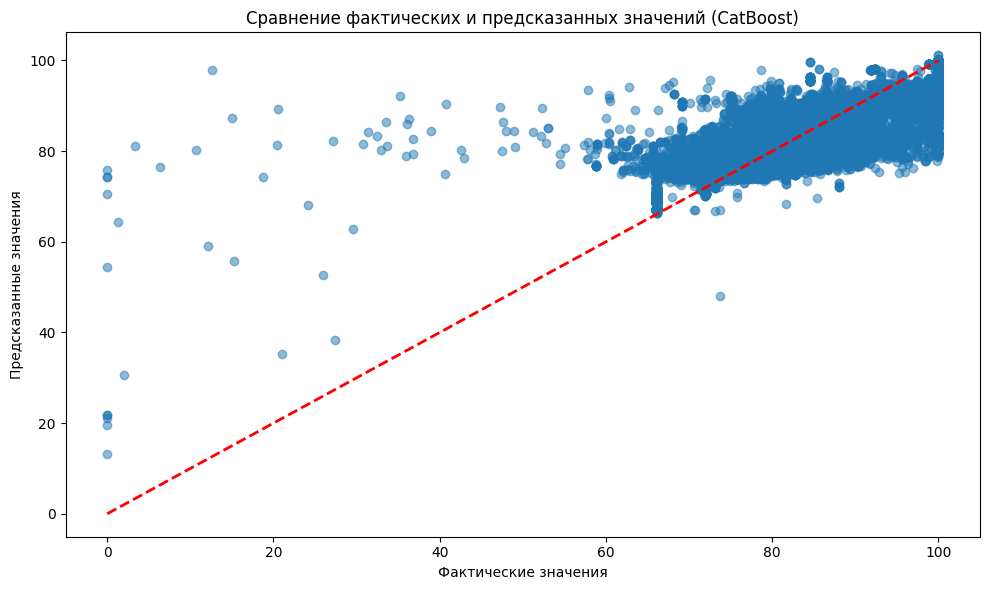

In [35]:
from sklearn.metrics import mean_squared_error, r2_score

# Делаем предсказания на тестовом наборе
y_pred_cat = cat_model.predict(X_scaled_test)

# Оцениваем качество модели
mse_cat = mean_squared_error(y_test, y_pred_cat)
rmse_cat = np.sqrt(mse_cat)
r2_cat = r2_score(y_test, y_pred_cat)

print("Метрики качества модели CatBoost на тестовой выборке:")
print(f"Среднеквадратичная ошибка (MSE): {mse_cat:.4f}")
print(f"Корень из среднеквадратичной ошибки (RMSE): {rmse_cat:.4f}") 
print(f"Коэффициент детерминации (R²): {r2_cat:.4f}")
from sklearn.metrics import median_absolute_error
mae_cat = median_absolute_error(y_test, y_pred_cat)
print(f"Медианная абсолютная ошибка (MAE): {mae_cat:.4f}")
print()

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_cat, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение фактических и предсказанных значений (CatBoost)')
plt.tight_layout()
plt.show()


## Делаем LinearRegression

In [36]:
from sklearn.linear_model import LinearRegression

# Создаем и обучаем модель линейной регрессии
lr_model = LinearRegression()
lr_model.fit(X_scaled_train, y_train)

# Делаем предсказания
y_pred_lr = lr_model.predict(X_scaled_test)

# Оцениваем качество модели
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

Метрики качества модели линейной регрессии на тестовой выборке:
Среднеквадратичная ошибка (MSE): 34.8520
Корень из среднеквадратичной ошибки (RMSE): 5.9036
Коэффициент детерминации (R²): 0.3538
Медианная абсолютная ошибка (MAE): 3.3300



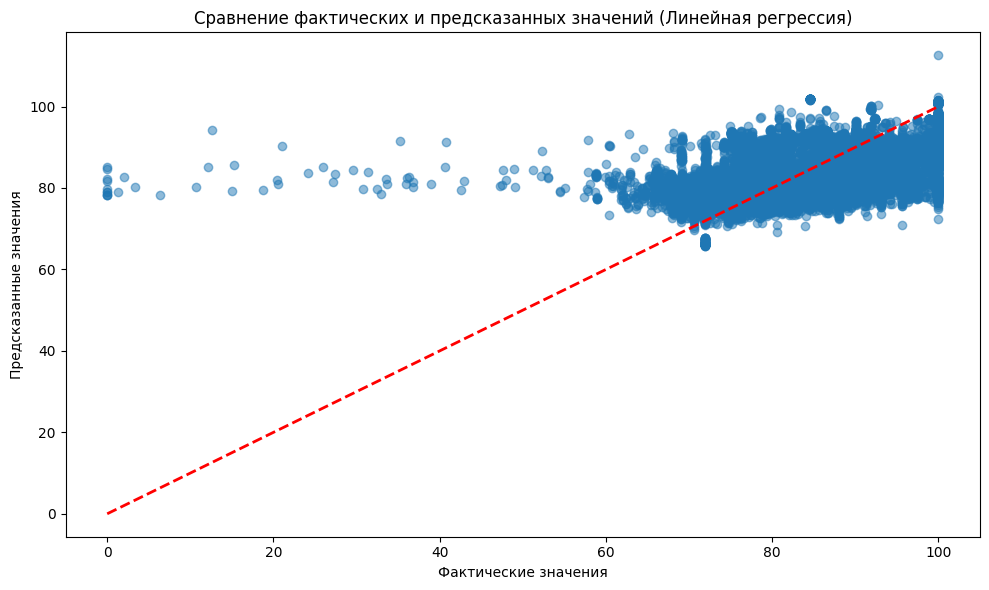

In [37]:
from sklearn.metrics import mean_squared_error, r2_score

# Делаем предсказания на тестовом наборе
y_pred_lr = lr_model.predict(X_scaled_test)

# Оцениваем качество модели
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Метрики качества модели линейной регрессии на тестовой выборке:")
print(f"Среднеквадратичная ошибка (MSE): {mse_lr:.4f}")
print(f"Корень из среднеквадратичной ошибки (RMSE): {rmse_lr:.4f}") 
print(f"Коэффициент детерминации (R²): {r2_lr:.4f}")
from sklearn.metrics import median_absolute_error
mae_lr = median_absolute_error(y_test, y_pred_lr)
print(f"Медианная абсолютная ошибка (MAE): {mae_lr:.4f}")
print()

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение фактических и предсказанных значений (Линейная регрессия)')
plt.tight_layout()
plt.show()
